# Lecture 7 : Matrices in C

## Clone the materials repo on github to access datafiles.

In [1]:
!git clone https://code.vt.edu/jasonwil/cmda3634_materials.git

Cloning into 'cmda3634_materials'...
remote: Enumerating objects: 172, done.
remote: Counting objects: 100% (135/135), done.
remote: Compressing objects: 100% (128/128), done.
remote: Total 172 (delta 48), reused 9 (delta 2), pack-reused 37 (from 1)
Receiving objects: 100% (172/172), 25.91 MiB | 14.48 MiB/s, done.
Resolving deltas: 100% (53/53), done.


## Copy the lecture 7 materials into our local workspace.

In [2]:
!cp cmda3634_materials/L07/* .

# Part 1 : Why Matrices?

## **It is common practice to store datasets using matrices.**

## A dataset with $len$ points in $\mathbb{R}^{dim}$ can be stored using a $len \times dim$ matrix where each row of the matrix contains one point of the dataset.

## For example, we could store $1000$ MNIST images using a $1000 \times 784$ matrix since each $28 \times 28$ MNIST image can be stored as a vector in $\mathbb{R}^{784}$.

## **Matrices are also crucial for numerical linear algebra which plays a crucial role in data and computational science.**

# Part 2 : Two-Dimensional Arrays in C

## Perhaps the most natural way of representing a matrix in C is using a **two-dimensional array**.  

## Working with **small** two-dimensional arrays in C is similar to other languages such as Python.

## Here is an example program that multiplies a $3 \times 2$ matrix by a vector in $\mathbb{R}^2$.


In [3]:
%%writefile matvec_v1.c
#include <stdio.h>

int main () {
    int m = 3; // m - number of rows of A
    int n = 2; // n - number of columns of A
    double A[3][2] = { { 0.5, 1 }, { 1, 2.5 }, { 4, -1.5 } };
    double x[2] = { 1, 1 };
    double b[3] = { 0 };
    // compute b = A*x
    for (int i=0;i<m;i++) {
        for (int j=0;j<n;j++) {
            b[i] += A[i][j]*x[j];
        }
    }
    printf ("b = { %.2f, %.2f, %.2f }\n",b[0],b[1],b[2]);
}

Writing matvec_v1.c


In [4]:
!gcc -o matvec_v1 matvec_v1.c

In [5]:
!./matvec_v1

b = { 1.50, 3.50, 2.50 }


## Unfortunately, two-dimensional arrays are not well supported by the C programming language.  

## Perhaps the biggest limitation occurs when trying to work with two-dimensional arrays that are very large and must be allocated on the heap.

## In the code below, C does not have enough information to be able to interpret the variable *A* as a two-dimensional array.

In [6]:
%%writefile limit_2d.c
#include <stdio.h>
#include <stdlib.h>

int main () {
    int m = 10000; // m - number of rows of A
    int n = 10000; // n - number of columns of A
    double* A = (double*)malloc(m*n*sizeof(double));
    A[0][0] = 0.5; // will not compile since A[0] has type double
}

Writing limit_2d.c


In [7]:
!gcc -o limit_2d limit_2d.c

limit_2d.c: In function ‘main’:
limit_2d.c:8:9: error: subscripted value is neither array nor pointer nor vector
    8 |     A[0][0] = 0.5; // will not compile since A[0] has type double
      |         ^


## **Since most of our datasets are far too large to put on the stack this is a major problem in C when trying to use matrices to store datasets.**

## There are two main workarounds to the problem encountered above.  

## The first workaround uses a table of row pointers.

## The second workaround involves flattening the two-dimensional array into a one-dimensional array.  

# Part 3 : First Workaround : Table of Row Pointers

## We illustrate the table of row pointers method using the same matrix vector multiplication as above.

In [8]:
%%writefile matvec_v2.c
#include <stdio.h>
#include <stdlib.h>

int main () {
    int m = 3; // m - number of rows of A
    int n = 2; // n - number of columns of A

    // allocate the mxn matrix A
    double* A[m];
    for (int i=0;i<m;i++) {
        A[i] = (double*)malloc(n*sizeof(double)); // allocate the ith row
        if (A[i] == NULL) {
            printf ("malloc failed to allocate A[i]\n");
        }
    }

    // initialize A, x, b
    A[0][0] = 0.5;
    A[0][1] = 1;
    A[1][0] = 1;
    A[1][1] = 2.5;
    A[2][0] = 4;
    A[2][1] = -1.5;
    double x[2] = { 1, 1 };
    double b[3] = { 0 };

    // calculate b = Ax
    for (int i=0;i<m;i++) {
        for (int j=0;j<n;j++) {
            b[i] += A[i][j]*x[j];
        }
    }
    printf ("b = { %.2f, %.2f, %.2f }\n",b[0],b[1],b[2]);

    // free the rows of A
    for (int i=0;i<m;i++) {
        free(A[i]);
    }
}

Writing matvec_v2.c


In [9]:
!gcc -o matvec_v2 matvec_v2.c

In [10]:
!./matvec_v2

b = { 1.50, 3.50, 2.50 }


## There is an alternate version that allocates the table of row pointers on the heap as well:

    double** A = (double**)malloc(m*sizeof(double*)); // allocate table of row pointers
    if (A == NULL) {
        printf ("malloc failed to allocate A\n");
        return 1;
    }

## This alternate method should be used for very large matrices for which the table of row pointers would not easily fit on the stack.

## With the alternate method be sure to free the rows of *A* before freeing *A* itself!

## The nice thing about this approach is that we can keep our nice syntax for accessing the ith row and jth column of A.  

    for (int i=0;i<m;i++) {
        for (int j=0;j<n;j++) {
            b[i] += A[i][j]*x[j];
        }
    }

## This approach also naturally extends to the case where the rows have variable size.  

## Although this method seems like a lot of work the process of allocating and freeing memory for two-dimensional arrays can be encapsulated into functions.

## This approach has advantages there are some downsides as well:

* ## The table of row pointers takes up additional memory.
* ## Since the row vectors are dynamically allocated one at a time, they may end up being far apart in memory which could have a negative impact on performance--this problem can be prevented by allocating all of the rows at the same time but that requires array flattening techniques.

# Part 4 : Second Workaround : Flat Arrays

## This is the most efficient approach for representing two-dimensional arrays in C.

## This approach also simplifies Python-C interoperability when working with matrices.  

## The downside of this approach is that we can no longer use our preferred two-dimensional array syntax A[i][j] for the element in $i^{th}$ row and $j^{th}$ column of A.

## In my opinion the upsides of this approach outweigh the downsides.

## **Thus, we will frequently use flat arrays when working with matrices in this class.**

## Consider the following 2d array.

$$
\begin{array}{|c|c|c|c|}
        \hline
        5 & -2 & 7 & 10 \\
        \hline
        -6 & 1 & 4 & 8 \\
          \hline
        9 & 0 & -5 & 3 \\
        \hline
        \end{array}
$$

## We could **flatten** the 2d array into a 1d array of size $12$ using **row-major order**.
        
$$
\begin{array}{|c|c|c|c|c|c|c|c|c|c|c|c|}
            \hline
           5 & -2 & 7 & 10 & -6 & 1 & 4 & 8 & 9 & 0 & -5 & 3 \\
            \hline
            \end{array}
$$

## We could also **flatten** the 2d array into a 1d array of size $12$ using **column-major order**.
        
$$
\begin{array}{|c|c|c|c|c|c|c|c|c|c|c|c|}
            \hline
           5 & -6 & 9 & -2 & 1 & 0 & 7 & 4 & -5 & 10 & 8 & 3 \\
            \hline
            \end{array}
$$

## When storing matrices as one-dimensional arrays in class we will use **row-major order** unless otherwise specified.  (Note that **column-major** ordering is often preferred for GPU codes).


## We can visualize how a 2d array is flattened into a 1d array using **row-major order** by putting the 1d indices into the 2d array.

$$
\begin{array}{|c|c|c|c|}
        \hline
        0 & 1 & 2 & 3 \\
        \hline
        4 & 5 & 6 & 7 \\
          \hline
        8 & 9 & 10 & 11 \\
        \hline
        12 & & & ? \\
        \hline
        & & & \\
        \hline
        & & & \\
        \hline
        & & & \\
        \hline
        & ?? & & \\
        \hline
        & & & \\
        \hline
        \end{array}
$$

## What index should go in the ? blank?

## **Answer**: $15$

## What index should go in the ?? blank?

## **Answer**: $29$

## Given a 2d array with $9$ rows and $4$ columns, give a formula for the 1d array index for the entry in row i and column j of the 2d array.

## **Answer**: $i*4+j$

## Given a 2d array with $m$ rows and $n$ columns, give a formula for the 1d array index for the entry in row i and column j of the 2d array.

## **Answer**: $i*n+j$



## We illustrate the flat array method using the same matrix vector multiplication example as above.

In [11]:
%%writefile matvec_v3.c
#include <stdio.h>
#include <stdlib.h>

int main () {
    int m = 3; // number of rows of A
    int n = 2; // number of columns of A

    // allocate a mxn matrix A using a flat array
    double* A = (double*)malloc(m*n*sizeof(double));
    if (A == NULL) {
        printf ("malloc failed to allocate A\n");
        return 1;
    }

    // initialize A, x, b
    A[0] = 0.5;
    A[1] = 1;
    A[2] = 1;
    A[3] = 2.5;
    A[4] = 4;
    A[5] = -1.5;
    double x[2] = { 1, 1 };
    double b[3] = { 0 };

    // calculate b = Ax
    for (int i=0;i<m;i++) {
        for (int j=0;j<n;j++) {
            // i*n+j is the 1d index of the row i column j entry of A
            // thus we replace A[i][j] with A[i*n+j]
            b[i] += A[i*n+j]*x[j];
        }
    }
    printf ("b = { %.2f, %.2f, %.2f }\n",b[0],b[1],b[2]);

    // free the matrix A
    free(A);
}

Writing matvec_v3.c


In [12]:
!gcc -o matvec_v3 matvec_v3.c

In [13]:
!./matvec_v3

b = { 1.50, 3.50, 2.50 }


# Part 5 : Extreme Pair

## We store the dataset using a flat $len \times dim$ matrix where $len$ is the number of data points and $dim$ is the dimension of each data point.  

In [14]:
%%writefile extreme_v1.c
#include <stdio.h>
#include <stdlib.h>
#include <math.h>

double vec_dist_sq (double* u, double* v, int dim) {
    double dist_sq = 0;
    for (int i=0;i<dim;i++) {
        dist_sq += (u[i]-v[i])*(u[i]-v[i]);
    }
    return dist_sq;
}

void vec_read_dataset (double* data, int len, int dim) {
    for (int i=0;i<len;i++) {
        for (int j=0;j<dim;j++) {
            if (scanf("%lf",&(data[i*dim+j])) != 1) {
                printf ("error reading dataset\n");
                exit(1);
            }
        }
    }
}

int main () {

    // read dataset with len points in R^dim
    int len, dim;
    if (scanf("%d %d",&len,&dim) != 2) {
        printf ("error reading the length and dimension of the dataset\n");
        return 1;
    }

    // allocate the (len x dim) data matrix on the heap using malloc
    double* data = (double*)malloc(len*dim*sizeof(double));
    if (data == NULL) {
        printf ("malloc failed to allocate data matrix\n");
        return 1;
    }

    // read the dataset
    vec_read_dataset (data,len,dim);

    // find the extreme pair
    double max_dist_sq = 0;
    int extreme_1, extreme_2;
    for (int i=0;i<len-1;i++) {
        for (int j=i+1;j<len;j++) {
            // data+i*dim is a pointer to the ith data point
            // data+j*dim is a pointer to the jth data point
            double dist_sq = vec_dist_sq(data+i*dim,data+j*dim,dim);
            if (dist_sq > max_dist_sq) {
                max_dist_sq = dist_sq;
                extreme_1 = i;
                extreme_2 = j;
            }
        }
    }

    // print the results
    printf ("The extreme pair has indices (%d,%d)\n",extreme_1,extreme_2);
    printf ("The distance between the extreme pair is %.2f\n",sqrt(max_dist_sq));

    // free the data matrix
    free (data);

}

Writing extreme_v1.c


In [15]:
!gcc -O3 -ffast-math -march=native -o extreme_v1 extreme_v1.c -lm

In [16]:
!time cat mnist2000.txt | ./extreme_v1

The extreme pair has indices (1618,1895)
The distance between the extreme pair is 3928.75

real	0m0.963s
user	0m0.943s
sys	0m0.023s


## Let's next visualize the extreme pair.

In [17]:
!cat mnist2000.txt | python3 mnist.py extreme.png 1618 1895

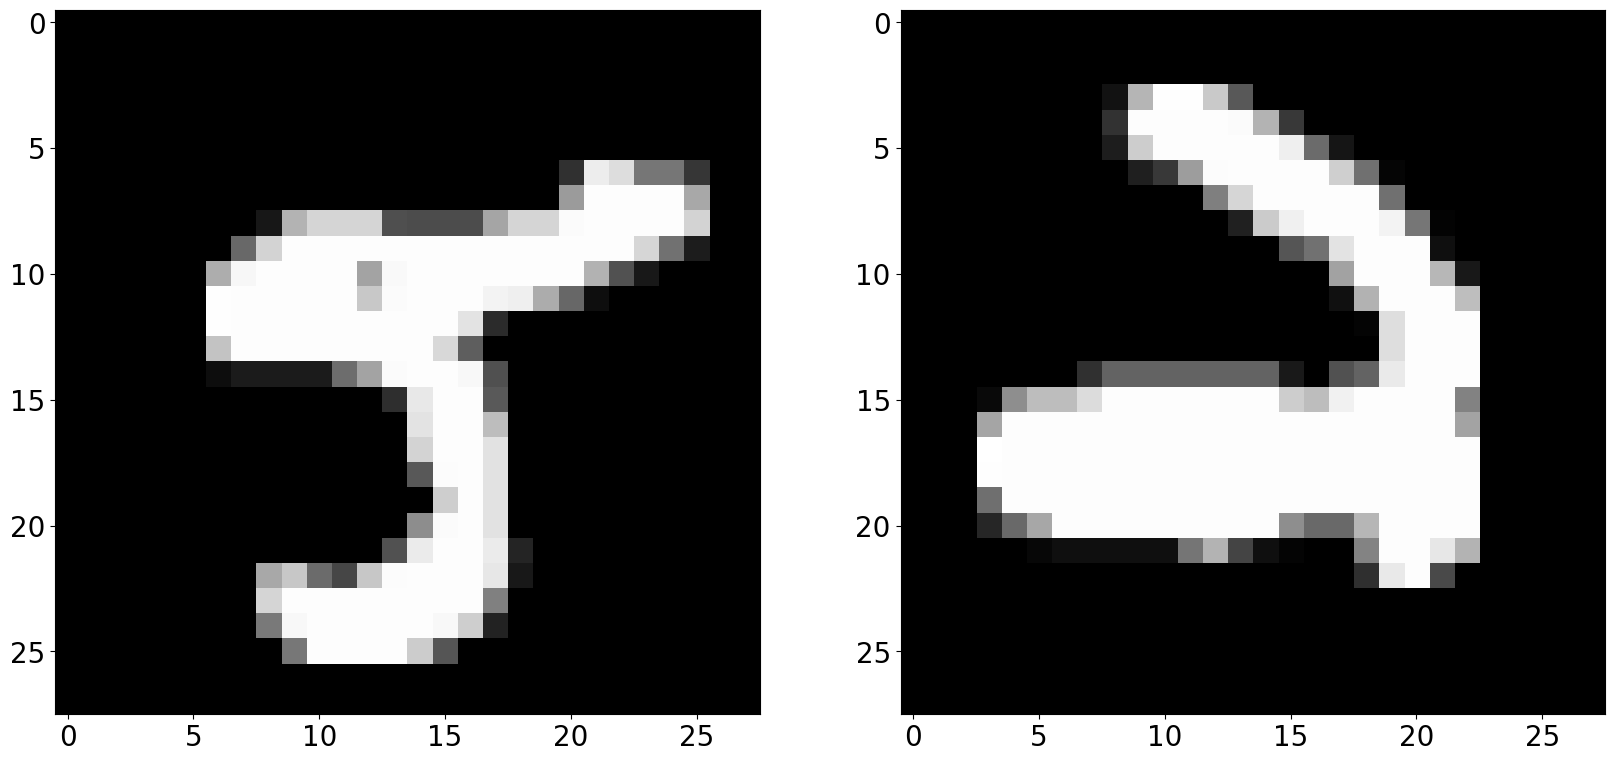

In [18]:
from IPython import display
display.Image("extreme.png")

# Part 6 : Using Header and Implementation Files

## As projects become more complicated we will avoid putting all of our code in a single source file.  

## We can use header (or interface) files (i.e. *.h*) and implementation files (i.e. *.c*) to move related type declarations and functions to their own files.  

## What functions are related in our extreme code?

## Let's get started with version 6 by first creating a *.h* file for our *vec* function interfaces.

## Note that we use the flag *VEC_H* to avoid having multiple copies of our header file included.  

## Multiple includes can happen if multiple header files are included that include the same header file.  

## This problem is more common on larger projects but it is good to get into the habit of preventing multiple includes now.  

## Note that the header file only contains type declarations and function *interfaces*.

## We typically avoid specifying *implementations* in our header files.

In [19]:
%%writefile vec.h
#ifndef VEC_H
#define VEC_H

double vec_dist_sq (double* u, double* v, int dim);

void vec_read_dataset (double* data, int len, int dim);

#endif

Writing vec.h


## Here is the corresponding *implementation* file.

In [20]:
%%writefile vec.c
#include <stdio.h>
#include <stdlib.h>
#include "vec.h"

double vec_dist_sq (double* u, double* v, int dim) {
    double dist_sq = 0;
    for (int i=0;i<dim;i++) {
        dist_sq += (u[i]-v[i])*(u[i]-v[i]);
    }
    return dist_sq;
}

void vec_read_dataset (double* data, int len, int dim) {
    for (int i=0;i<len;i++) {
        for (int j=0;j<dim;j++) {
            if (scanf("%lf",&(data[i*dim+j])) != 1) {
                printf ("error reading dataset\n");
                exit(1);
            }
        }
    }
}

Writing vec.c


## Finally, here is our main source file that takes advantage of the separation of the *vec* functionality.

## Note that we include our new header file using:
    #include "vec.h"

In [21]:
%%writefile extreme.c
#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include "vec.h"

int main () {

    // read dataset with len points in R^dim
    int len, dim;
    if (scanf("%d %d",&len,&dim) != 2) {
        printf ("error reading the length and dimension of the dataset\n");
        return 1;
    }

    // allocate the (len x dim) data matrix on the heap using malloc
    double* data = (double*)malloc(len*dim*sizeof(double));
    if (data == NULL) {
        printf ("malloc failed to allocate data matrix\n");
        return 1;
    }

    // read the dataset
    vec_read_dataset (data,len,dim);

    // find the extreme pair
    double max_dist_sq = 0;
    int extreme_1, extreme_2;
    for (int i=0;i<len-1;i++) {
        for (int j=i+1;j<len;j++) {
            // data+i*dim is a pointer to the ith data point
            // data+j*dim is a pointer to the jth data point
            double dist_sq = vec_dist_sq(data+i*dim,data+j*dim,dim);
            if (dist_sq > max_dist_sq) {
                max_dist_sq = dist_sq;
                extreme_1 = i;
                extreme_2 = j;
            }
        }
    }

    // print the results
    printf ("The extreme pair has indices (%d,%d)\n",extreme_1,extreme_2);
    printf ("The distance between the extreme pair is %.2f\n",sqrt(max_dist_sq));

    // free the data matrix
    free (data);

}

Writing extreme.c


## To build our new program we need to add the source file *vec.c* to our compile command.

In [22]:
!gcc -O3 -ffast-math -march=native -o extreme extreme.c vec.c -lm

In [23]:
!time cat mnist2000.txt | ./extreme

The extreme pair has indices (1618,1895)
The distance between the extreme pair is 3928.75

real	0m1.119s
user	0m1.058s
sys	0m0.029s


# Part 7 : Using Shell Scripts to Automate


## Here is a shell script that compiles and runs extreme.

## Note that *$?* returns the exit value of the last executed command.

## Recall that a program such as gcc returns 0 if successful.

## Note that *$1* is the first command line argument to our shell script.

## For this script the first command line argument will specify the data file.

## Note that *$#* is the number of command line arguments.

In [24]:
%%writefile compile_run.sh
echo 'Compiling extreme'
gcc -O3 -ffast-math -march=native -o extreme extreme.c vec.c -lm
if [ $? -ne 0 ]; then
  echo 'Error : Compilation Failed.'
  exit 1
fi
if [ $# -eq 0 ]; then
  echo 'Error: No data filename provided.'
  exit 1
fi
echo -n 'Running extreme on file: '
echo $1
time cat $1 | ./extreme

Writing compile_run.sh


## We run our shell script using the *bash* command.

## Let's first run on the 2d dataset.

In [25]:
!bash compile_run.sh points1k.txt

Compiling extreme
Running extreme on file: points1k.txt
The extreme pair has indices (446,911)
The distance between the extreme pair is 2.78

real	0m0.005s
user	0m0.007s
sys	0m0.000s


## Let's run on the MNIST dataset with 2000 images.

In [26]:
!bash compile_run.sh mnist2000.txt

Compiling extreme
Running extreme on file: mnist2000.txt
The extreme pair has indices (1618,1895)
The distance between the extreme pair is 3928.75

real	0m0.999s
user	0m0.972s
sys	0m0.031s


## Let's check our error handling in the case where a filename is not given.

In [27]:
!bash compile_run.sh

Compiling extreme
Error: No data filename provided.


## Finally, we introduce a typo by changing extreme.c to extremes.c.

## This typo will cause a compilation error which will terminate our script.

In [28]:
%%writefile compile_run.sh
echo 'Compiling extreme'
gcc -O3 -ffast-math -march=native -o extreme extremes.c vec.c -lm
# Remember that a program such as gcc returns 0 if successful.
if [ $? -ne 0 ]; then
  echo 'Error : Compilation Failed.'
  exit 1
fi
if [ $# -eq 0 ]; then
  echo 'Error: No data filename provided.'
  exit 1
fi
echo -n 'Running extreme on file: '
echo $1
time cat $1 | ./extreme

Overwriting compile_run.sh


In [29]:
!bash compile_run.sh mnist2000.txt

Compiling extreme
cc1: fatal error: extremes.c: No such file or directory
compilation terminated.
Error : Compilation Failed.
